## ワークスペースと接続

In [ ]:
import azure.ai.ml 
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azureml.core import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')


try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    # This will open a browser page for
    credential = InteractiveBrowserCredential()

try:
    ml_client = MLClient.from_config(credential=credential)
except Exception as ex:
    # NOTE: Update following workspace information if not correctly configure before
    client_config = {
        "subscription_id": ws.subscription_id,
        "resource_group": ws.resource_group,
        "workspace_name": ws.name,
    }

    if client_config["subscription_id"].startswith("<"):
        print(
            "please update your <SUBSCRIPTION_ID> <RESOURCE_GROUP> <AML_WORKSPACE_NAME> in notebook cell"
        )
        raise ex
    else:  # write and reload from config file
        import json, os

        config_path = "../.azureml/config.json"
        os.makedirs(os.path.dirname(config_path), exist_ok=True)
        with open(config_path, "w") as fo:
            fo.write(json.dumps(client_config))
        ml_client = MLClient.from_config(credential=credential, path=config_path)
print(ml_client)

## データ探索

In [2]:
# load the training dataset
!wget -P ./data https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv

import pandas as pd
file_path = './data/daily-bike-share.csv'
bike_data = pd.read_csv(file_path)
bike_data.head()

--2022-06-23 08:46:22--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48800 (48K) [text/plain]
Saving to: ‘./data/daily-bike-share.csv’

daily-bike-share.cs 100%[===================>]  47.66K  --.-KB/s    in 0.008s  

2022-06-23 08:46:23 (5.54 MB/s) - ‘./data/daily-bike-share.csv’ saved [48800/48800]



,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


In [3]:
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
bike_data.head(32)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,1
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,2
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,3
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,4
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,5
5,6,1/6/2011,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,6
6,7,1/7/2011,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,7
7,8,1/8/2011,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,8
8,9,1/9/2011,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,9
9,10,1/10/2011,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,10


instant: 一意の行識別子

dteday: データが観察された日付 - この場合、データは毎日収集されました。したがって、日付ごとに1行あります。

season: 季節を示す数値エンコードされた値 (1:春、2:夏、3:秋、4:冬)

yr: 観察が行われた研究の年(研究は2年間にわたって行われた - 0年は2011年を表し、1年は2012年を表す)

mnth:観測が行われた暦月(1:1月...12:12月)

holiday: 観測が祝日に行われたかどうかを示すバイナリ値)

weekday: 観測が行われた曜日(0:日曜日...6:土曜日)

workingday: その日が稼働日であるかどうかを示すバイナリ値 (週末または休日ではない)

weathersit: 気象状況を示すカテゴリ値 (1:晴れ、2:霧/雲、3:小雨/雪、4:大雨/雹/雪/霧)

temp: 摂氏温度 (正規化)

atemp: 摂氏 (正規化) 単位の見かけの ("感じのよい") 温度

hum: 湿度レベル (正規化)

windspeed: 風速 (正規化)

rentals: 記録された自転車レンタルの数

In [4]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
bike_data[numeric_features + ['rentals']].describe()

,temp,atemp,hum,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471
std,0.183051,0.162961,0.142429,0.077498,686.622488
min,0.059130,0.079070,0.000000,0.022392,2.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000
50%,0.498333,0.486733,0.626667,0.180975,713.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000


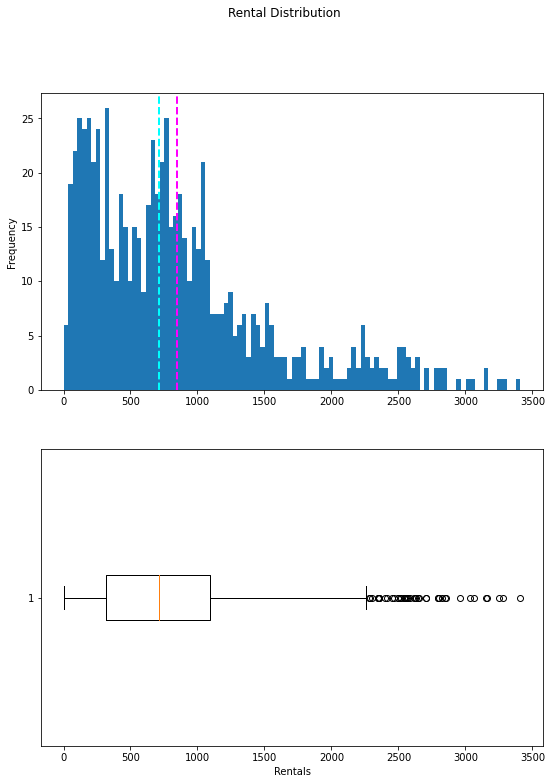

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the Jupyter notebook
%matplotlib inline

# Get the label column
label = bike_data['rentals']


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Rentals')

# Add a title to the Figure
fig.suptitle('Rental Distribution')

# Show the figure
fig.show()


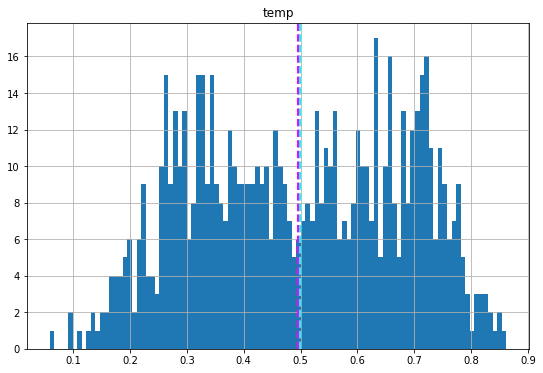

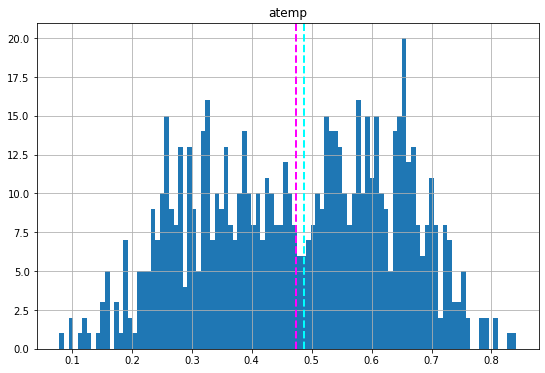

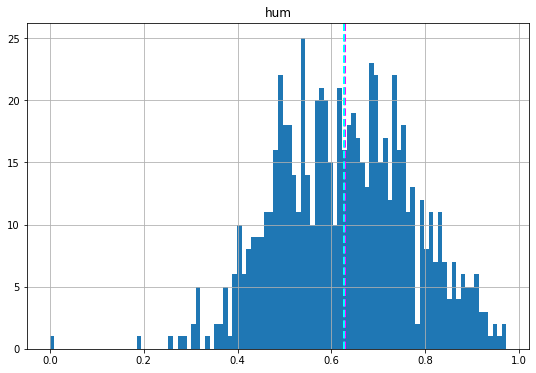

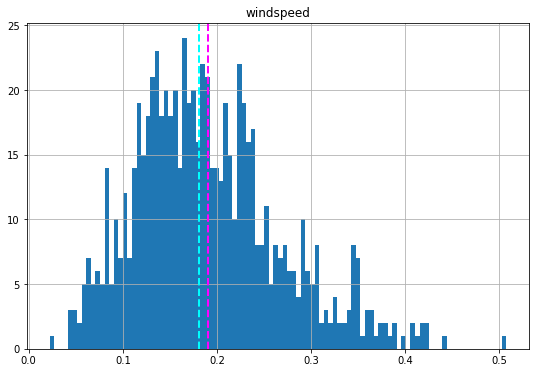

In [6]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_data[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

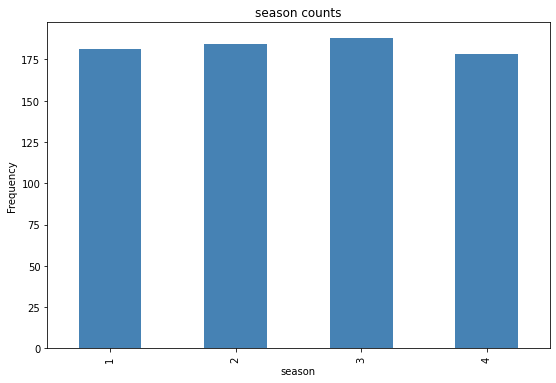

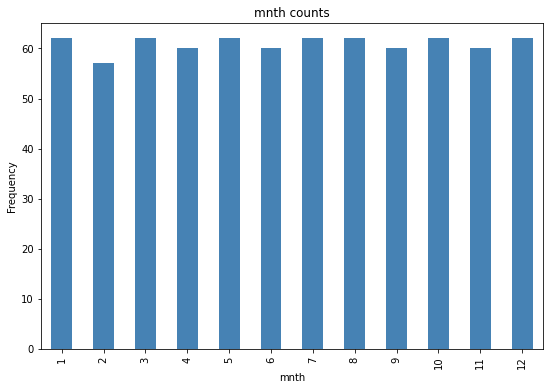

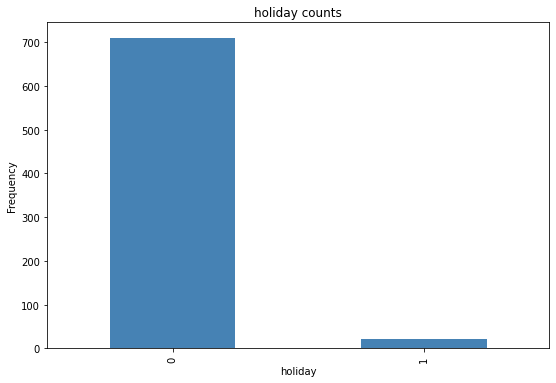

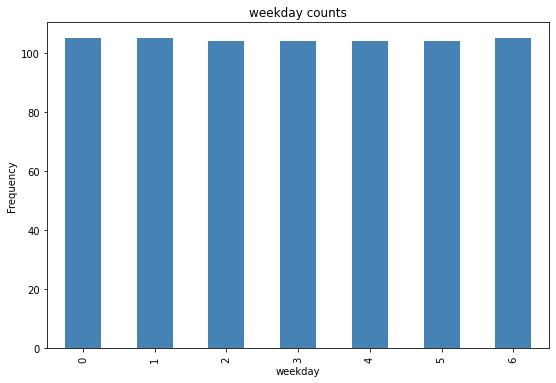

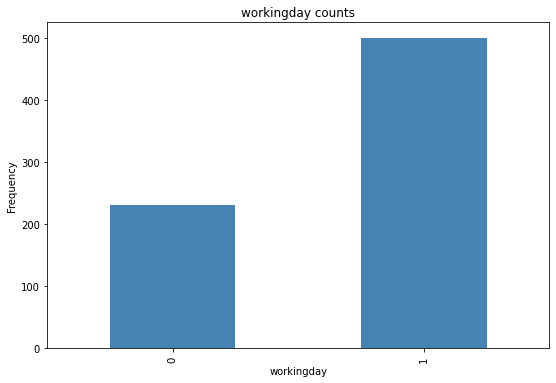

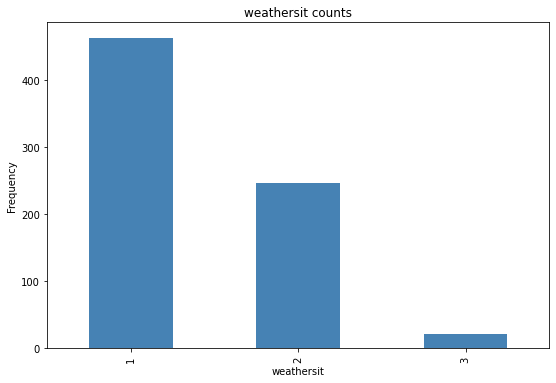

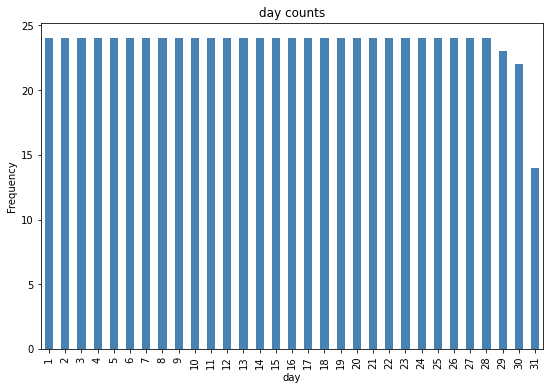

In [7]:
import numpy as np

# plot a bar plot for each categorical feature count
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']

for col in categorical_features:
    counts = bike_data[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()


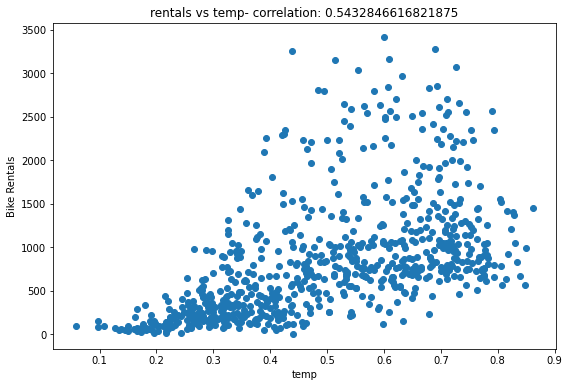

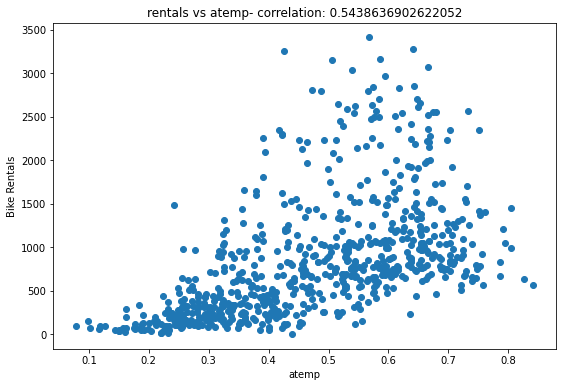

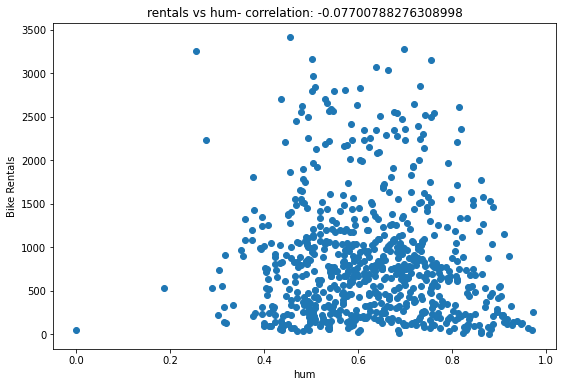

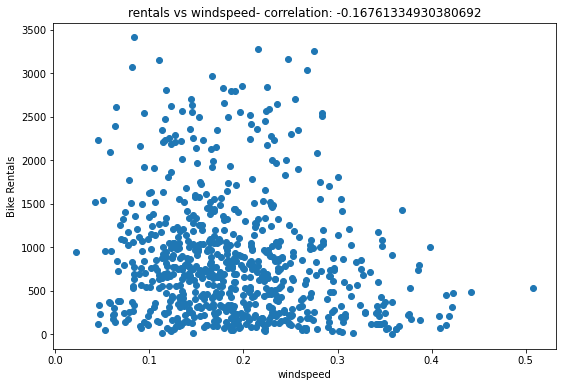

In [8]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_data[col]
    label = bike_data['rentals']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Bike Rentals')
    ax.set_title('rentals vs ' + col + '- correlation: ' + str(correlation))
plt.show()


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-

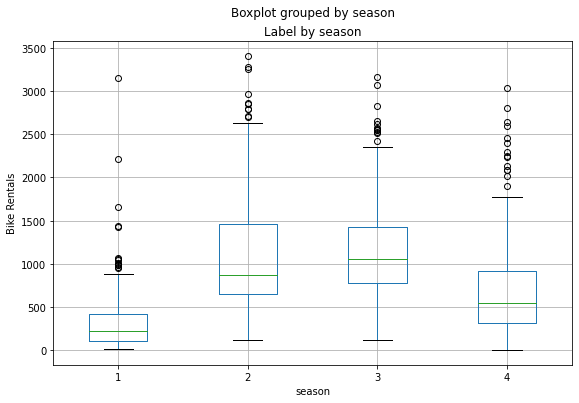

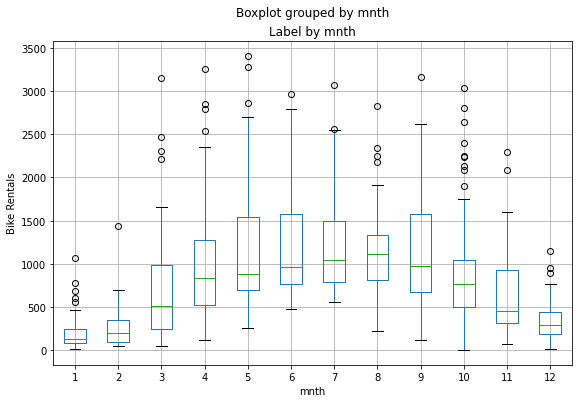

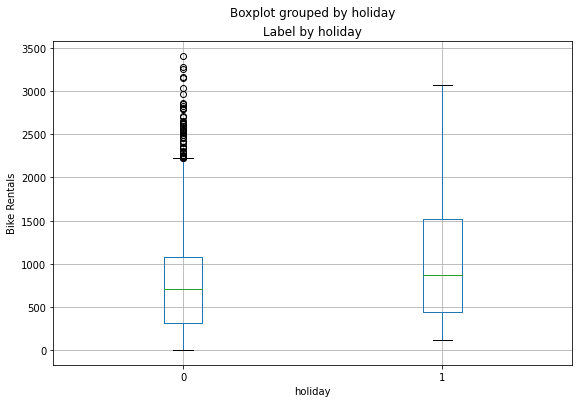

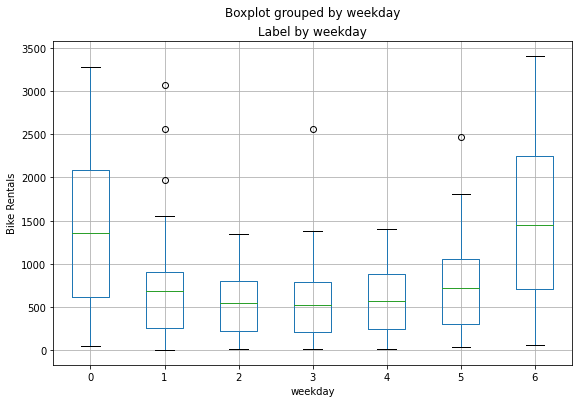

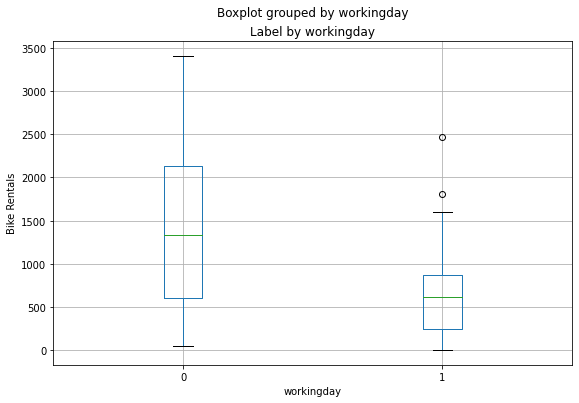

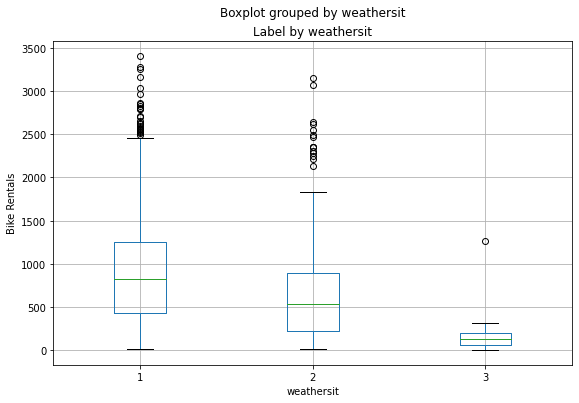

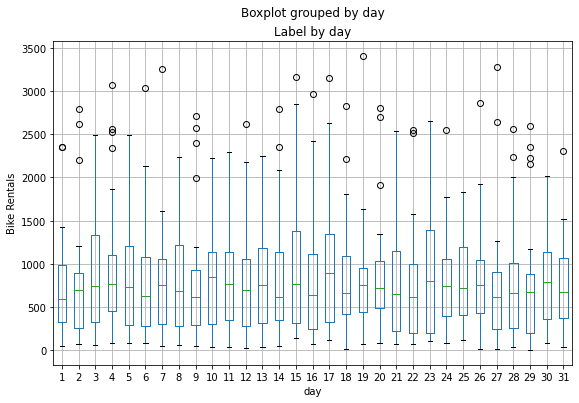

In [9]:
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_data.boxplot(column = 'rentals', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Bike Rentals")
plt.show()